#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
import control as ct

s = ct.TransferFunction.s
%matplotlib inline
import emcee
import time
from multiprocessing import Pool
import corner

#experiment params
set_t = 77

#### Functions to run the show

##### Scaling

In [ ]:
def unnormalise(tempcol_normalized, set_t):
    templist = list(max(tempcol) - (tempcol_normalized * (max(tempcol) - set_t)))
    return np.array(templist)

In [ ]:
def normalise(tempcol, set_t):
    templist = list((max(tempcol) - np.array(tempcol)) / (max(tempcol) - set_t))
    return np.array(templist)

##### log file reader

In [ ]:
def log_file_reader(filename):

    # Load data from file
    datetimecol = []
    tempcol = []


    try:
        with open(filename) as f:
            for line in f:
                temp = line.strip().split()
                datetimecol.append(temp[0] + ' ' + temp[1])
                tempcol.append(float(temp[2]))

        # Convert datetime strings to datetime objects
        time_series = pd.to_datetime(datetimecol)

        # Calculate elapsed time in seconds since the start
        elapsed_time_seconds = (time_series - time_series[0]).total_seconds()
        return [elapsed_time_seconds, tempcol]

    except:
        with open(filename) as f:
            for line in f:
                temp = line.strip().split(',')
                datetimecol.append(temp[0])
                tempcol.append(float(temp[1]))

        # Convert datetime strings to datetime objects
        time_series = pd.to_datetime(datetimecol)

        # Calculate elapsed time in seconds since the start
        elapsed_time_seconds = (time_series - time_series[0]).total_seconds()
        return [elapsed_time_seconds, tempcol]

##### Basic plotter

In [ ]:
def basic_plotter(name, x, y, set_t, save):
    #plt.figure(figsize=(2, 3))  # Specify width and height as a tuple
    plt.plot(x, y, label = f'{name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.axhline(set_t, linestyle='--', linewidth = 0.5,  color='m', label = 'Set point')

    plt.legend(loc="best")

    if save:
        plt.savefig(f'log_1309_{name}.pdf', dpi=300)
    plt.show()

### Loading the log file and plot to check

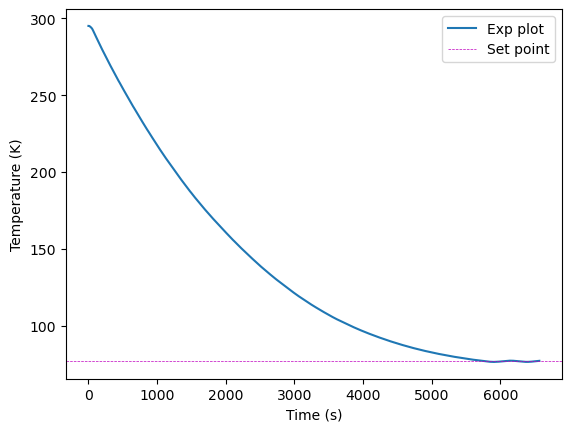

In [ ]:
[elapsed_time_seconds, tempcol] = log_file_reader("templog_2024-09-13_12-50-37_to_2024-09-13_14-40-03.txt")

basic_plotter('Exp plot', elapsed_time_seconds, tempcol, set_t, False)

### Interpolate the read data to regularize it

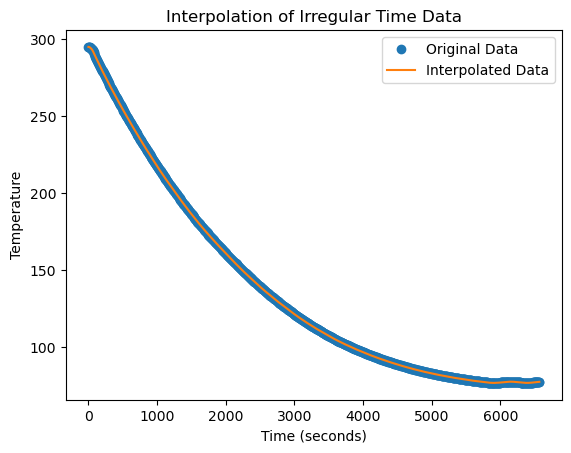

Data saved to 'interpolated_data.txt'


In [ ]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
elapsed_time_seconds = np.array(elapsed_time_seconds)
tempcol = np.array(tempcol)

# Define the regular grid
regular_time = np.linspace(0, max(elapsed_time_seconds), 6566)
# Interpolate using linear interpolation
interp_function = interp.interp1d(elapsed_time_seconds, tempcol, kind='linear', fill_value="extrapolate")
regular_temp = interp_function(regular_time)

# Plotting for visualization
plt.plot(elapsed_time_seconds, tempcol, 'o', label='Original Data')
plt.plot(regular_time, regular_temp, '-', label='Interpolated Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature')
plt.legend()
plt.title('Interpolation of Irregular Time Data')
plt.show()

data_to_save = np.column_stack((regular_time, regular_temp))

# Save to a .txt file in CSV format
np.savetxt('interpolated_data_77k.txt', data_to_save, delimiter=',')

print("Data saved to 'interpolated_data.txt'")

tempcol = tempcol.tolist()
elapsed_time_seconds = elapsed_time_seconds.tolist()
regular_time = regular_time.tolist()
regular_temp = regular_temp.tolist()

### Fit algorithm for finding the correct w_n and damp_f using mcmc

In [ ]:
def model_get_control(w_n, damp_f, time_):
    time_ = np.array(time_)
    kp = 5
    ki = 0.5
    kd = 0.2

    kp_new = 5
    ki_new = 0.5
    kd_new = 0.2

    P = (w_n ** 2) / (((s ** 2) * kd + s * kp + ki) * (s + 2 * w_n * damp_f))
    C = ((kd_new*(s**2)) + (kp_new*s) + ki_new)/s

    T = ct.feedback(P * C, 1)
    #print(type(T))
    _, y_model = ct.step_response(T, time_)

    return np.array(y_model)

In [ ]:
import numpy as np
import control as ct

def model_get_control_step(w_n, damp_f, time_, num_points=2500):
    # Use a coarser time vector
    time_ = np.linspace(time_[0], time_[-1], num_points)

    kp_new = 5
    ki_new = 0.5
    kd_new = 0.2

    # Define s
    s = ct.TransferFunction([1, 0], [1])  # This creates the 's' variable

    # Define the transfer functions
    P = (w_n ** 2) / (((s ** 2) * kd_new + s * kp_new + ki_new) * (s + 2 * w_n * damp_f))
    C = (kd_new * (s**2) + kp_new * s + ki_new) / s

    # Closed-loop transfer function
    T = ct.feedback(P * C, 1)

    # Step response
    _, y_model = ct.step_response(T, time_)

    return np.array(y_model), time_

In [ ]:
def lnlike(x, time, y_exp_, yerr_):

    # x ---> w_n, damp_f
    y_model_, _ = model_get_control_step(*x, time)
    inv_sigma2 = 1.0/(yerr_**2)

    return -0.5*(np.sum((y_exp_-y_model_)**2*inv_sigma2 - np.log(inv_sigma2) + np.log(2.*np.pi)))

def lnprior(x, bounds_):

    # Constructing conditions
    conditions_met = 1
    conditions_met &= all((bounds_[i][0] < x[i] < bounds_[i][1]) for i in range(len(x)))

    return 0.0 if conditions_met else -np.inf

def lnpost(x, time, y_exp_, yerr_, bounds_):

    lnp = lnprior(x, bounds_)

    if not np.isfinite(lnp):
        return -np.inf

    templike = lnlike(x, time, y_exp_, yerr_)
    temp = lnp + templike
    return temp

In [ ]:
guess = [0.9, 7]   # w_n, damp_f
bounds = [[2,10], [2,10]]  # w_n, damp_f

yerr = 1e-2

ndim = 2  # Number of parameters

nwalkers = 50  # Number of walkers
nsteps = 60000  # Number of steps
pert = 1e-4 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 1000  # Adjust based on your specific case
thin = 5
noofcores = 30

p0 = [guess + pert * np.random.randn(ndim) for i in range(nwalkers)]

start = time.time()
with Pool(processes=noofcores) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(np.array(regular_time), np.array(regular_temp), yerr, bounds), pool = pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████████████████████████████| 60000/60000 [10:27:53<00:00,  1.59it/s]

Multiprocessing took 37674.5 seconds


In [ ]:
# Assuming 'sampler' is your emcee.EnsembleSampler object
samples = sampler.get_chain(discard=15000, thin=5, flat=True)  # Discard the burn-in samples and thin the chain
samples_all =  sampler.get_chain(discard=15000, thin=1, flat=True)
# Calculate the mean of the posterior distributions
mean_values = np.mean(samples, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values = np.median(samples, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs = np.std(samples, axis=0)
print("Standard deviations:", std_devs)

# # If you want to find the MAP estimate (the sample with the highest posterior probability)
# # Note: This requires the log_prob_fn to be the posterior probability function
# log_probs = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)
# max_prob_index = np.argmax(log_probs)
# map_estimate = samples[max_prob_index]
# print("MAP estimate:", map_estimate)

Mean values: [0.01728771 4.29997659]
Median values: [0.00420053 3.71589864]
Standard deviations: [0.09425606 1.36806087]


In [ ]:
symbols_list = ['w_n', 'damp_f']

In [ ]:
# Assuming sampler is your emcee.EnsembleSampler object
samples_all = sampler.get_chain(discard=10000)
#print(samples)

# Plot the traces of the parameters
fig_samples_all, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = symbols_list

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_ylim(6,6.2)
    ax.axhline(y=mean_values[i], color='y', linestyle='--', linewidth=1, label = 'mean value')

axes[-1].set_xlabel("Step number")
plt.legend(loc = 'upper right')
plt.show()

/home/saurabhs/anaconda3/lib/python3.11/site-packages/arviz/data/base.py:265: UserWarning: More chains (60000) than draws (50). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


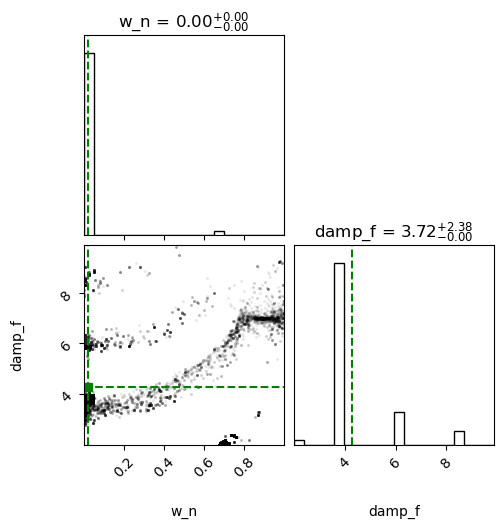

In [ ]:
plt.style.use('default')
# Create the corner plot
figure_corner = corner.corner(samples_all, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 12})

# Access the axes in the corner plot
axes = figure_corner.axes

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i * ndim + i]
    ax.axvline(mean_values[i], color="g", linestyle="--", label="Mean")

# Loop over the scatter plots (off-diagonal)
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi * ndim + xi]
        # Add vertical and horizontal lines at the mean and map estimate
        ax.axvline(mean_values[xi], color="g", linestyle="--")
        ax.axhline(mean_values[yi], color="g", linestyle="--")
        # Plot points for mean and map estimate
        ax.plot(mean_values[xi], mean_values[yi], "sg")

#figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)

#### Test new step response generator with less data points in step response with control library output

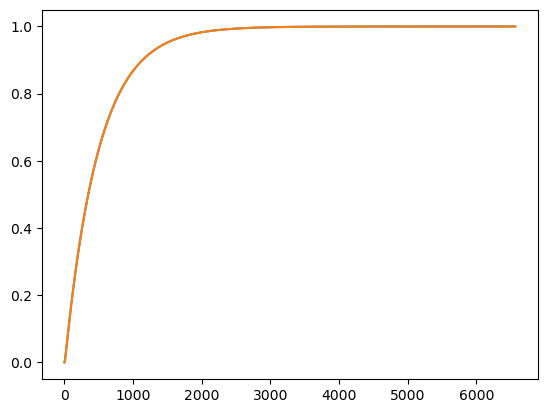

In [ ]:
plt.plot(regular_time, model_get_control(*mean_values[::-1], regular_time), label = 'mcmc')
plt.plot(model_get_control_step(*mean_values[::-1], regular_time)[1], model_get_control_step(*mean_values[::-1], regular_time)[0], label = 'mcmc')

#### Compare MCMC and experimental time series

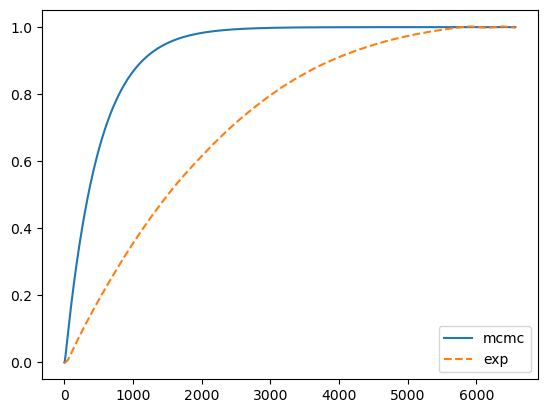

In [ ]:
plt.plot(regular_time, model_get_control(*mean_values[::-1], regular_time), label = 'mcmc')
plt.plot(regular_time, normalise(regular_temp, 77),  label = 'exp', linestyle='--')

plt.legend()

#### Checking all solutions and peaks

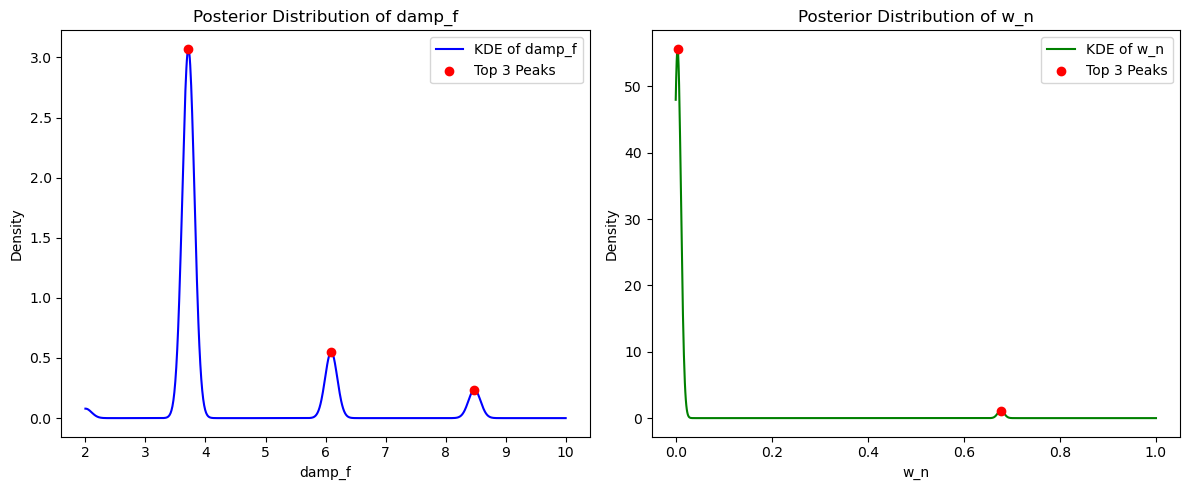

Top three peaks for damp_f: [8.47847848 6.09209209 3.71371371]
Top three peaks for w_n: [0.67667668 0.004004  ]

Accepted value for damp_f: 0.017287709154709792
Accepted value for w_n: 0.017287709154709792


In [ ]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extracting the parameters
w_n_samples = samples[:, 0]
damp_f_samples = samples[:, 1]

# Kernel Density Estimation for damp_f
kde_damp_f = gaussian_kde(damp_f_samples)
x_damp_f = np.linspace(bounds[1][0], bounds[1][1], 1000)
y_damp_f = kde_damp_f(x_damp_f)

# Kernel Density Estimation for w_n
kde_w_n = gaussian_kde(w_n_samples)
x_w_n = np.linspace(bounds[0][0], bounds[0][1], 1000)
y_w_n = kde_w_n(x_w_n)

# Finding peaks for damp_f
peaks_damp_f, properties_damp_f = find_peaks(y_damp_f)

# Finding peaks for w_n
peaks_w_n, properties_w_n = find_peaks(y_w_n)

# Extracting peak heights and sorting
damp_f_peak_heights = y_damp_f[peaks_damp_f]
w_n_peak_heights = y_w_n[peaks_w_n]

# Getting top three peaks
top_damp_f_peaks_indices = np.argsort(damp_f_peak_heights)[-3:]  # Indices of top 3 peaks
top_damp_f_peaks = x_damp_f[peaks_damp_f][top_damp_f_peaks_indices]
top_damp_f_heights = damp_f_peak_heights[top_damp_f_peaks_indices]

top_w_n_peaks_indices = np.argsort(w_n_peak_heights)[-3:]  # Indices of top 3 peaks
top_w_n_peaks = x_w_n[peaks_w_n][top_w_n_peaks_indices]
top_w_n_heights = w_n_peak_heights[top_w_n_peaks_indices]

# Plotting the results
plt.figure(figsize=(12, 5))

# Damp_f Plot
plt.subplot(1, 2, 1)
plt.plot(x_damp_f, y_damp_f, label='KDE of damp_f', color='blue')
plt.scatter(top_damp_f_peaks, top_damp_f_heights, color='red', zorder=5, label='Top 3 Peaks')
plt.title('Posterior Distribution of damp_f')
plt.xlabel('damp_f')
plt.ylabel('Density')
plt.legend()

# w_n Plot
plt.subplot(1, 2, 2)
plt.plot(x_w_n, y_w_n, label='KDE of w_n', color='green')
plt.scatter(top_w_n_peaks, top_w_n_heights, color='red', zorder=5, label='Top 3 Peaks')
plt.title('Posterior Distribution of w_n')
plt.xlabel('w_n')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Outputting the top three peaks
print("Top three peaks for damp_f:", top_damp_f_peaks)
print("Top three peaks for w_n:", top_w_n_peaks)

print('\nAccepted value for damp_f: '+ str(mean_values[::-1][1]))
print('Accepted value for w_n: '+ str(mean_values[::-1][1]))

#### Tweaking params and checking

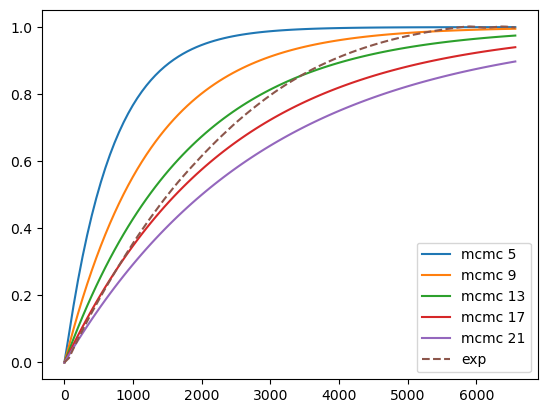

In [ ]:
for i in range(5, 25, 4):
    plt.plot(regular_time, model_get_control(*[i, 0.01457], regular_time), label = f'mcmc {i}')

plt.plot(regular_time, normalise(regular_temp, 77),  label = 'exp', linestyle='--')
plt.legend()

### IRT tweaker and plotter

In [ ]:
%matplotlib qt
from matplotlib.widgets import Slider, Button

# Get initial output
y_mcmc, time = model_get_control_step(*list(mean_values), regular_time)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

# Plot the experimental response
ax1.plot(regular_time, regular_temp, label='Experimental', color='orange')

# Plot the MCMC response
line_1, = ax1.plot(time, unnormalise(y_mcmc,77), label='MCMC', color='blue')
ax1.set_ylabel('Time response')
ax1.grid(True)
ax1.legend()

# Plot the difference between MCMC and Experimental on the second subplot
difference = np.array(unnormalise(y_mcmc, 77)) - np.array(regular_temp)
line_2 = ax2.plot(time, difference, label='MCMC - Exp', color='purple')
ax2.set_ylabel('Difference')
ax2.grid(True)
ax2.legend()

# Create slider axes
axis = plt.axes([0.75, 0.75, 0.14, 0.05])
axis2 = plt.axes([0.75, 0.65, 0.14, 0.05])

# Create sliders
slider1 = Slider(axis, 'w_n', mean_values[0] - 25, mean_values[0] + 25, valinit=mean_values[0])
slider2 = Slider(axis2, "damp_f", mean_values[1] - 0, mean_values[1] + 150, valinit=mean_values[1])

# Create button axes for arrows
button_ax1_up = plt.axes([0.85, 0.75, 0.025, 0.025])
button_ax1_down = plt.axes([0.75, 0.75, 0.025, 0.025])
button_ax2_up = plt.axes([0.85, 0.65, 0.025, 0.025])
button_ax2_down = plt.axes([0.75, 0.65, 0.025, 0.025])

# Create buttons
button1_up = Button(button_ax1_up, '^', color='lightgoldenrodyellow')
button1_down = Button(button_ax1_down, 'v', color='lightgoldenrodyellow')
button2_up = Button(button_ax2_up, '^', color='lightgoldenrodyellow')
button2_down = Button(button_ax2_down, 'v', color='lightgoldenrodyellow')

# Update function
def update(val):
    new_mean_values = [slider1.val, slider2.val]

    # Get updated output based on new mean values
    y_mcmc, _ = model_get_control_step(*new_mean_values, regular_time)

    # Update the line data for MCMC
    line_s11.set_ydata(unnormalise(y_mcmc, 77))
    line_2 = ax2.plot(time, difference, label='MCMC - Exp', color='purple')

    # Redraw the figures
    fig.canvas.draw_idle()

# Attach the update function to the sliders
slider1.on_changed(update)
slider2.on_changed(update)

# Button functions for sliders
def adjust_slider(slider, delta):
    slider.set_val(slider.val + delta)
    update(None)

least_count = 0.01
button1_up.on_clicked(lambda event: adjust_slider(slider1, least_count))
button1_down.on_clicked(lambda event: adjust_slider(slider1, -least_count))
button2_up.on_clicked(lambda event: adjust_slider(slider2, least_count))
button2_down.on_clicked(lambda event: adjust_slider(slider2, -least_count))

# Create button axes for the reset button
reset_button_ax = plt.axes([0.75, 0.35, 0.14, 0.05])  # Adjust position as needed
reset_button = Button(reset_button_ax, 'Reset', color='lightgoldenrodyellow')

# Define the reset function
def reset(event):
    slider1.set_val(mean_values[0])
    slider2.set_val(mean_values[1])
    update(None)  # Call update to refresh the plot

# Connect the reset button to the reset function
reset_button.on_clicked(reset)

plt.show()


### Least Squares based fitting to time response

#### Third order plant

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import lti, step

# Define the third-order transfer function model
def transfer_function(t, K, a0, a1, a2):
    # Compute the step response
    t_out, y_out = step(lti([K], [1, a2, a1, a0]), T=t)
    return y_out

# Perform least squares fitting
params, covariance = curve_fit(transfer_function, regular_time, normalise(regular_temp,77))

# Extract fitted parameters
K_fit, a0_fit, a1_fit, a2_fit = params
print(f"Fitted parameters:\nK = {K_fit}\na0 = {a0_fit}\na1 = {a1_fit}\na2 = {a2_fit}")

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

y_final = transfer_function(regular_time, *params)
# Plot the original data and the fitted model
axs[0].plot(regular_time, normalise(regular_temp,77), label='Data', color='blue')
axs[0].plot(regular_time, y_final, label='Fitted model', color='red')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Response')
axs[0].legend()
axs[0].set_title('Data and Fitted Model')
axs[0].grid()

# Plot the residuals
axs[1].plot(regular_time, np.abs(y_final-normalise(regular_temp,77)), label='Residuals', color='green')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Residuals')
axs[1].legend()
axs[1].set_title('Residuals of the Fit')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

Fitted parameters:
K = 9.787502252498584e-05
a0 = 9.022780222816674e-05
a1 = 0.2081729643028323
a2 = 20.52777223173919


#### Fourth order plant

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import lti, step

# Define the fourth-order transfer function model
def transfer_function(t, K, a0, a1, a2, a3):
    # Define the transfer function
    num = [K]  # Numerator coefficients (K)
    den = [1, a3, a2, a1, a0]  # Denominator coefficients (s^4 + a3*s^3 + a2*s^2 + a1*s + a0)

    # Create a continuous-time system
    system = lti(num, den)

    # Compute the step response
    t_out, y_out = step(system, T=t)

    return y_out

params, covariance = curve_fit(transfer_function, regular_time, normalise(regular_temp,77))

# Extract fitted parameters
K_fit, a0_fit, a1_fit, a2_fit, a3_fit = params

print(f"Fitted parameters:\nK = {K_fit}\na0 = {a0_fit}\na1 = {a1_fit}\na2 = {a2_fit}\na3 = {a3_fit}")

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

y_final = transfer_function(regular_time, *params)
# Plot the original data and the fitted model
axs[0].plot(regular_time, normalise(regular_temp,77), label='Data', color='blue')
axs[0].plot(regular_time, y_final, label='Fitted model', color='red')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Response')
axs[0].legend()
axs[0].set_title('Data and Fitted Model')
axs[0].grid()

# Plot the residuals
axs[1].plot(regular_time, np.abs(y_final-normalise(regular_temp,77)), label='Residuals', color='green')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Residuals')
axs[1].legend()
axs[1].set_title('Residuals of the Fit')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

Fitted parameters:
K = 1.0
a0 = 1.0
a1 = 1.0
a2 = 1.0
a3 = 1.0


/tmp/ipykernel_1195801/1903331786.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(transfer_function, regular_time, normalise(regular_temp,77))


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the original data and the fitted model
axs[0].plot(regular_time, regular_temp, label='Data', color='blue')
axs[0].plot(regular_time, unnormalise(y_final,77), label='Fitted model', color='red')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (K)')
axs[0].legend()
axs[0].set_title('Data and Fitted Model')
axs[0].grid()

# Plot the residuals
axs[1].plot(regular_time, unnormalise(y_final,77)-regular_temp , label='Residuals', color='green')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Residuals(K)')
axs[1].legend()
axs[1].set_title('Residuals of the Fit')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()